# Bayesian logistic regression

Author: [Nipun Batra](https://nipunbatra.github.io/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymc3 as pm
from sklearn.datasets import make_blobs
import arviz as az
import theano.tensor as tt

rc('font', size=16)
rc('text', usetex=True)

Let us generate a pseudo-random dataset for logistic regression.

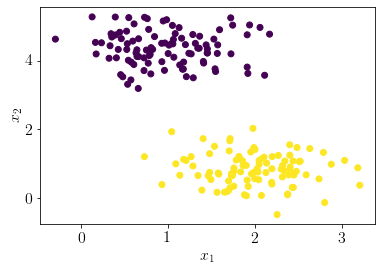

In [2]:
np.random.seed(0)
X, y = make_blobs(n_samples=200, n_features=2,cluster_std=0.5, centers=2)

plt.scatter(X[:, 0], X[:, 1],c=y);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');

Adding extra column of ones to incorporate the bias.

In [3]:
X_concat = np.hstack((np.ones((len(y), 1)), X))
X_concat.shape

(200, 3)

We define the bayesian logistic regression model as the following. Notice that we need to use Bernoulli likelihood as our output is binary.

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=0, sigma=100, shape=3)
    #theta = pm.Uniform("theta", upper=50, lower=-50, shape=3)
    X_ = pm.Data('features', X_concat)
    # Expected value of outcome
    
    y_hat = pm.math.sigmoid(tt.dot(X_, theta))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", p=y_hat, observed=y)

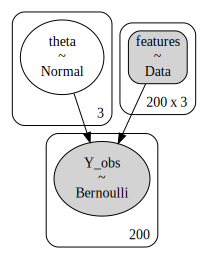

In [5]:
pm.model_to_graphviz(basic_model.model)

Let us get MAP for the parameter posterior.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'theta': array([20.12421332,  3.69334159, -9.60226941])}

Let us visualize the optimal seperating hyperplane.

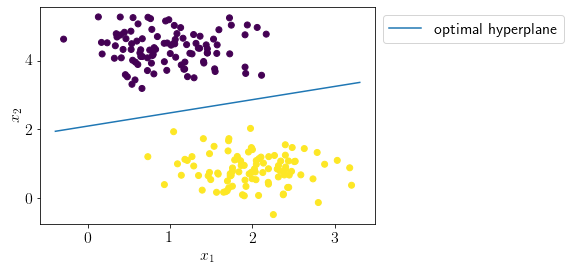

In [7]:
#separating hyperplane; X\theta = 0
def hyperplane(x, theta): 
    return (-theta[1]*x-theta[0]) /(theta[2])

x = np.linspace(X[:, 0].min()-0.1, X[:, 0].max()+0.1, 100)
plt.plot(x, hyperplane(x, map_estimate['theta']), label='optimal hyperplane')
plt.scatter(X[:, 0], X[:, 1],c=y);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.legend(bbox_to_anchor=(1,1));

Let us draw a large number of samples from the posterior.

In [8]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(2000,return_inferencedata=False,tune=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 45 seconds.
There were 780 divergences after tuning. Increase `target_accept` or reparameterize.
There were 772 divergences after tuning. Increase `target_accept` or reparameterize.
There were 397 divergences after tuning. Increase `target_accept` or reparameterize.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Let us visualize the parameter posterior.

/home/patel_zeel/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

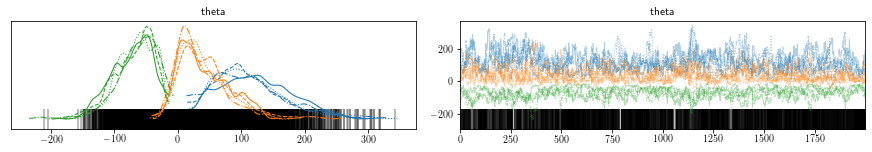

In [9]:
az.plot_trace(trace)

Let us predict for new input locations.

In [10]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [11]:
X_test = np.c_[xx.ravel(), yy.ravel()]
X_test_concat = np.hstack((np.ones((len(X_test), 1)), X_test))

In [12]:
with basic_model:
    pm.set_data({'features': X_test_concat})
    posterior = pm.sample_posterior_predictive(trace)

In [13]:
Z = posterior['Y_obs']

Following plot shows the posterior distribution over the hyperplanes.

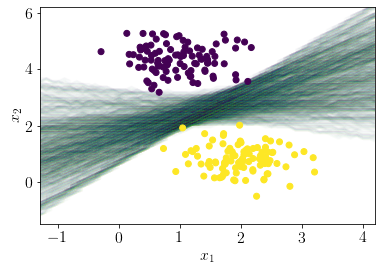

In [14]:
for i in range(len(Z))[:500]:
    plt.contour(xx, yy, Z[i].reshape(xx.shape), alpha=0.01)
plt.scatter(X[:, 0], X[:, 1],c=y, zorder=10);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');

Following code is inspired from": https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

The following plot show probabilities of being in any of the class for any arbitrary sample in the space. 

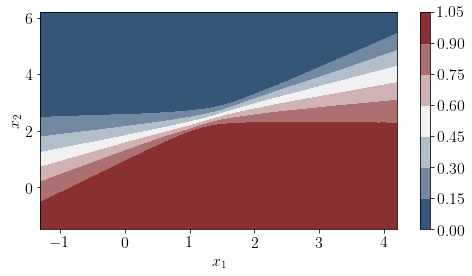

In [15]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].mean(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');

The following plot shows uncertainty in the predictions at any arbitrary location in input space.

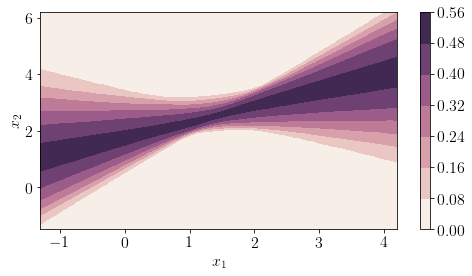

In [16]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].std(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');